In [14]:
import os
from typing import TypedDict,List,Dict,Any,Optional
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
import google.generativeai as genai
import os


c:\Users\ZAID\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
API_KEY=os.environ["API_KEY"]

In [15]:
genai.configure(api_key=API_KEY)

model = genai.GenerativeModel("gemini-2.5-flash")  # or "gemini-pro"

In [4]:
class EmailState(TypedDict):
    email:Dict[str,Any]
    is_spam:Optional[bool]
    spam_reason:Optional[str]
    email_category: Optional[str]
    email_draft:Optional[str]
    message:List[Dict[str,Any]]

In [23]:
def read_email(state:EmailState):
    email=state['email']
    print(f"An AI Agent is processing an email from {email['sender']} with subject {email['subject']}")
    return {}

def classify_email(state:EmailState):
    email=state['email']
    prompt =f"""
    As a professional email reader, analyze this email and determine if it is spam or legitimate and should be brought to Zaid's attention.

    Email:
    From : {email['sender']}
    Subject : {email['subject']}
    Body : {email['body']}

    First determine if this email is spam.
    answer with SPAM or HAM if it's legitimate. Only return answer
    Answer : 
"""
    
    response=model.generate_content(prompt)

    response_text=response.text.lower().strip()
    print(response_text)

    is_spam="spam" in response_text and "ham" not in response_text

    if not is_spam:
        new_message=state.get("message",[])+[{"role":"user","content":prompt},{"role":"assistant","content":response.text}]
    else:
        new_message=state.get("message",[])

    return {
        "is_spam":is_spam,
        "message":new_message
    }

def handle_spam(state:EmailState):
    print("Model has marked email as spam")
    print("The mail has been moved to the spam folder")
    return {}


def drafting_response(state:EmailState):
    email=state["email"]

    prompt=f"""

    As an AI agent, draft a polite preliminary response to this email.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    Draft a brief professional response that zaid can review and personalize before sending
    """

    response=model.generate_content(prompt)

    new_message=state.get("message",[])+[{"role":"user","content":prompt},{"role":"assistant","content":response.text}]

    return{
        "email_draft":response.text,
        "message":new_message
    }

def notify_zaid(state:EmailState):
    email=state['email']

    print("\n"+"="*50)
    print(f"Hello, I am you AI agent and you have received an email from {email['sender']}")
    print(f"subject : {email['subject']}")
    print("-"*50)
    print(state['email_draft'])
    print("="*50 + "\n")

    return {}



In [6]:
# defining the routing logic 

def route_email(state:EmailState):
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

In [25]:
# create the graph

email_graph=StateGraph(EmailState)

In [26]:
# Add Nodes 

email_graph.add_node("read_email",read_email)
email_graph.add_node("classify_email",classify_email)
email_graph.add_node("handle_spam",handle_spam)
email_graph.add_node("drafting_response",drafting_response)
email_graph.add_node("notify_zaid",notify_zaid)

In [27]:
email_graph.add_edge(START,"read_email")
email_graph.add_edge("read_email","classify_email")

# add conditional edge
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam":"handle_spam",
        "legitimate":"drafting_response"
    }
)

email_graph.add_edge("handle_spam",END)
email_graph.add_edge("drafting_response","notify_zaid")
email_graph.add_edge("notify_zaid",END)

In [28]:
compiled_graph=email_graph.compile()

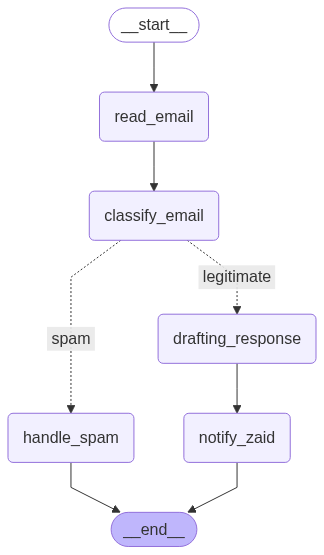

In [29]:
from IPython.display import Image, display
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [31]:
legitimate_email = {
    "sender": "John Doe - University of Toronto",
    "subject": "Regarding Research Collaboration on AI Ethics",
    "body": (
        "Dear Zaid,\n\n"
        "I have been following your work at Microsoft and was impressed by your recent publication "
        "on responsible AI. I am currently coordinating a research project on AI governance, and "
        "I believe there is a strong overlap in our interests. Would you be open to a quick call "
        "next week to explore possible collaboration opportunities?\n\n"
        "Best regards,\n"
        "John Doe\n"
        "Assistant Professor, University of Toronto"
    )
}


spam_email = {
    "sender": "Crypto bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some !"
}
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []})



Processing legitimate email...
An AI Agent is processing an email from John Doe - University of Toronto with subject Regarding Research Collaboration on AI Ethics
ham

Hello, I am you AI agent and you have received an email from John Doe - University of Toronto
subject : Regarding Research Collaboration on AI Ethics
--------------------------------------------------
Subject: Re: Regarding Research Collaboration on AI Ethics

Dear John,

Thank you for your email and for your kind words regarding my recent publication on responsible AI. I truly appreciate you reaching out and following my work.

I'm certainly interested in learning more about your research project on AI governance, as I agree there appears to be a strong overlap with my work in AI ethics. I believe there's significant potential for a fruitful discussion.

I'd be happy to explore potential collaboration opportunities with you. To help me prepare and ensure we make the most of a potential call, would you be able to share 